In [1]:
import copy
import json, pickle
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit.primitives import BackendEstimator
from qiskit_ibm_runtime import Estimator as RuntimeEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima, FakeSherbrooke, FakeLimaV2, FakeWashington
from qiskit import QuantumCircuit, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel
from noise_utils import AddNoise

from functools import partial

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *

D = {'output': 'mpl', 'fold': -1, 'idle_wires': False}

In [2]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [3]:
real_backend = provider.get_backend('ibm_sherbrooke')
# real_backend = provider.get_backend('ibm_washington')

In [4]:
fake_backend = FakeSherbrooke() #FakeWashington() #FakeLima()

## Local
fake_backend_ideal = QasmSimulator() # Noiseless
fake_backend_noisy = AerSimulator.from_backend(fake_backend) # Noisy
stabilizer_simulator = AerSimulator(method='stabilizer')

fake_run_config_ideal = {'shots': 10000, 'backend': fake_backend_ideal, 'name': 'fake_ideal'}
fake_run_config_noisy = {'shots': 10000, 'backend': fake_backend_noisy, 'name': 'fake_noisy'}

In [5]:
from qiskit.circuit import Parameter

class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = 4
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)

        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_100q_paper(self):
            self['nq'] = 100
            self['h'] = 0.5*np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_6q_paper(self):
            self['nq'] = 6
            self['h'] = np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_10q_paper(self):
            self['nq'] = 10
            self['h'] = 0.5*np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_10q_paper_2(self):
            self['nq'] = 10
            self['h'] = 0.66*np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)

        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()

    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qc = QuantumCircuit(ops['nq'])
        allq = list(range(ops['nq']))

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        if ops['measure_basis'] == 'Z':
            pass
        elif  ops['measure_basis'] == 'X':
            qc.h(allq)
        elif  ops['measure_basis'] == 'Y':
            qc.sdg(allq)
            qc.h(allq)
        else:
            raise Exception("Must be X Y or Z")
        qc.measure_all()

        return qc

    @classmethod
    def make_circs_sweep(cls, ops, num_steps, measure_basis):
        ops['measure_basis'] = measure_basis
        ops['depth'] = num_steps
        qc = cls.make_quantum_circuit(ops)
        qc.metadata = {}
        qc.metadata['measure_basis'] = measure_basis
        qc.metadata['depth'] = num_steps
        return qc

In [6]:
sherbrooke_layout = list(range(113, 127)) + [112] + list(range(108, 93, -1)) + [90] + list(range(75, 90)) + [74] + list(range(70, 55, -1)) + [52] + list(range(37, 52)) + [36, 32, 31, 30, 17] + list(range(12, 3, -1)) + [15, 22, 23, 24, 25, 26, 27, 28]

print(len(sherbrooke_layout))

100


In [7]:
washington_layout = list(range(113, 127)) + [112] + list(range(108, 93, -1)) + [90] + list(range(75, 90)) + [74] + list(range(70, 55, -1)) + [52] + list(range(37, 52)) + [36] + list(range(32, 17, -1)) + [14] + list(range(0, 5))

print(len(washington_layout))

100


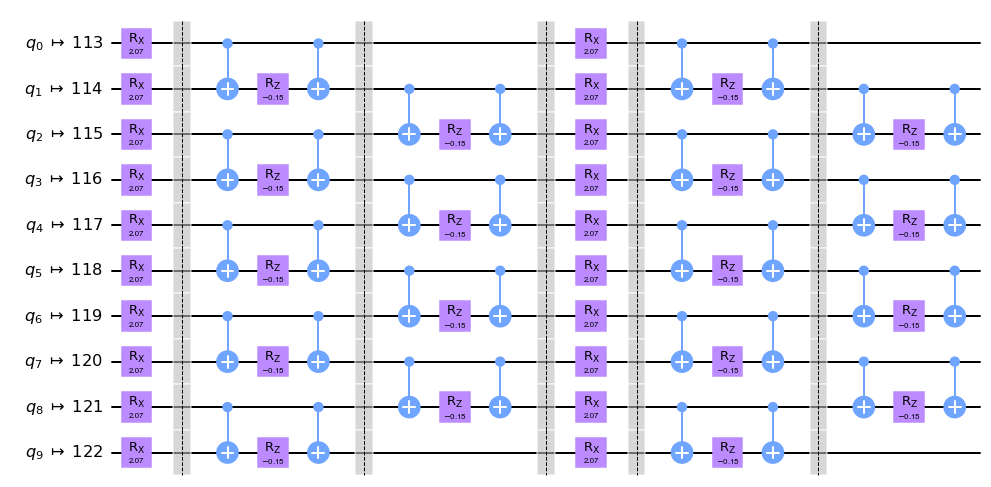

In [9]:
def construct_ising_circuit_100q(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_100q_paper()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

def construct_ising_circuit_6q(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_6q_paper()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

def construct_ising_circuit_10q(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_10q_paper()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

def construct_ising_circuit_10q_2(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_10q_paper_2()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

J = 0.15
basis = 'Z'
random_ising = construct_ising_circuit_10q_2(J, basis, 2)
trans_circuit = transpile(
    random_ising,
    backend=fake_backend_ideal,
    optimization_level=1,
    # initial_layout=washington_layout,
    # initial_layout=list(range(113, 119)),
    initial_layout=list(range(113, 123)),
)
trans_circuit.remove_final_measurements()
trans_circuit.draw(**D)

In [14]:
def form_all_qubit_observable(observable, measurement_qubits, total_num_qubits):
    """Input observable in non-endian, output observable in endian"""
    assert len(observable) == len(measurement_qubits)
    converted_obs = list('I' * total_num_qubits)
    for qubit, basis in zip(measurement_qubits, list(observable)):
        converted_obs[qubit] = basis
    return ''.join(converted_obs)[::-1]

def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

def construct_random_ising_func(num_steps, be, num_q):
    basis = 'Z'
    if num_q == 6:
        J = np.random.uniform(0, np.pi, size=1)[0]
        random_ising = construct_ising_circuit_6q(J, basis, num_steps)
    elif num_q == 100:
        J = np.random.uniform(0, np.pi/2, size=1)[0]
        random_ising = construct_ising_circuit_100q(J, basis, num_steps)
    elif num_q == 10:
        # J = np.random.uniform(0, np.pi/2, size=1)[0]
        J = np.random.uniform(0, np.pi * 0.66, size=1)[0]
        random_ising = construct_ising_circuit_10q(J, basis, num_steps)
    else:
        raise NotImplementedError
    trans_circuit = transpile(
        random_ising,
        backend=be,
        optimization_level=1,
        # initial_layout=washington_layout,
        # initial_layout=list(range(113, 119)),
        initial_layout=list(range(113, 123)),
    )
    return trans_circuit, J

def form_all_qubit_observable(observable, measurement_qubits, total_num_qubits):
    """Input observable in non-endian, output observable in endian"""
    assert len(observable) == len(measurement_qubits)
    converted_obs = list('I' * total_num_qubits)
    for qubit, basis in zip(measurement_qubits, list(observable)):
        converted_obs[qubit] = basis
    return ''.join(converted_obs)[::-1]

def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

def get_Js(num_Js, num_q):
    np.random.seed(0)
    if num_q == 6:
        h = np.pi
    elif num_q == 100:
        h = np.pi/2
    elif num_q == 10:
        # h = np.pi/2
        h = np.pi * 0.66
    else:
        raise NotImplementedError
    return np.random.uniform(0, h, size=num_Js)

def construct_random_ising_sameJ_func(J, be, num_q, num_steps):
    basis = 'Z'
    if num_q == 6:
        random_ising = construct_ising_circuit_6q(J, basis, num_steps)
    elif num_q == 100:
        random_ising = construct_ising_circuit_100q(J, basis, num_steps)
    elif num_q == 10:
        random_ising = construct_ising_circuit_10q(J, basis, num_steps)
    else:
        raise NotImplementedError
    trans_circuit = transpile(
        random_ising,
        backend=be,
        optimization_level=1,
        # initial_layout=washington_layout,
        # initial_layout=list(range(113, 119)),
        initial_layout=list(range(113, 123)),
    )
    return trans_circuit, J

In [15]:
from qiskit.transpiler.exceptions import TranspilerError
import scipy

def generate_data(generating_func, two_q_gate_depths, save_path: str, n_entries_per_file: int, be, num_q):
    Js = get_Js(n_entries_per_file, num_q)
    for depth in two_q_gate_depths:
        entries = []

        random_ising = construct_ising_circuit_10q(J=0, basis='Z', num_steps=depth)
        trans_circuit = transpile(
            random_ising,
            backend=be,
            optimization_level=0,
            # initial_layout=washington_layout,
            # initial_layout=list(range(113, 119)),
            initial_layout=list(range(113, 123)),
        )
        to_append = dict()
        to_append['circuit'] = trans_circuit
        to_append['steps'] = depth
        to_append['J'] = 0
        entries.append(to_append)

        for i in tqdm_notebook(range(1, n_entries_per_file)):
            success = False
            while not success:
                try:
                    trans_circuit, J = generating_func(J=Js[i], num_steps=depth)
                    success = True
                except (scipy.linalg.LinAlgError, TranspilerError, np.linalg.LinAlgError) as e:
                    print(f"Ran into an error:, {e}")

            to_append = dict()
            to_append['circuit'] = trans_circuit
            to_append['steps'] = depth
            to_append['J'] = J
            entries.append(to_append)

        path = "%s/step_%02d.pk"%(save_path, depth)
        with open(path, "wb") as f:
            pickle.dump(entries, f)

random.seed(0)
np.random.seed(0)
steps = list(range(1, 11))
generate_data(partial(construct_random_ising_sameJ_func, be=real_backend, num_q=10), steps,
              './data/ising_zne_hardware/10q_sherbrooke_sameJ_2', 30, real_backend, num_q=10)

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

In [59]:
with open('./data/ising_zne_hardware/10q_sherbrooke_sameJ/step_04.pk', 'rb') as file:
    loaded = pickle.load(file)

J = loaded[29]['J']
J

0.6513494521987603

In [16]:
import os
from tqdm.notebook import tqdm
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)])
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                # ideal_exp_vals.append(entry['ideal_exp_value'])
                # noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits #, ideal_exp_vals, noisy_exp_vals

train_circuits = load_circuits('./data/ising_zne_hardware/10q_sherbrooke_sameJ_2', '.pk')

  0%|          | 0/10 [00:00<?, ?it/s]

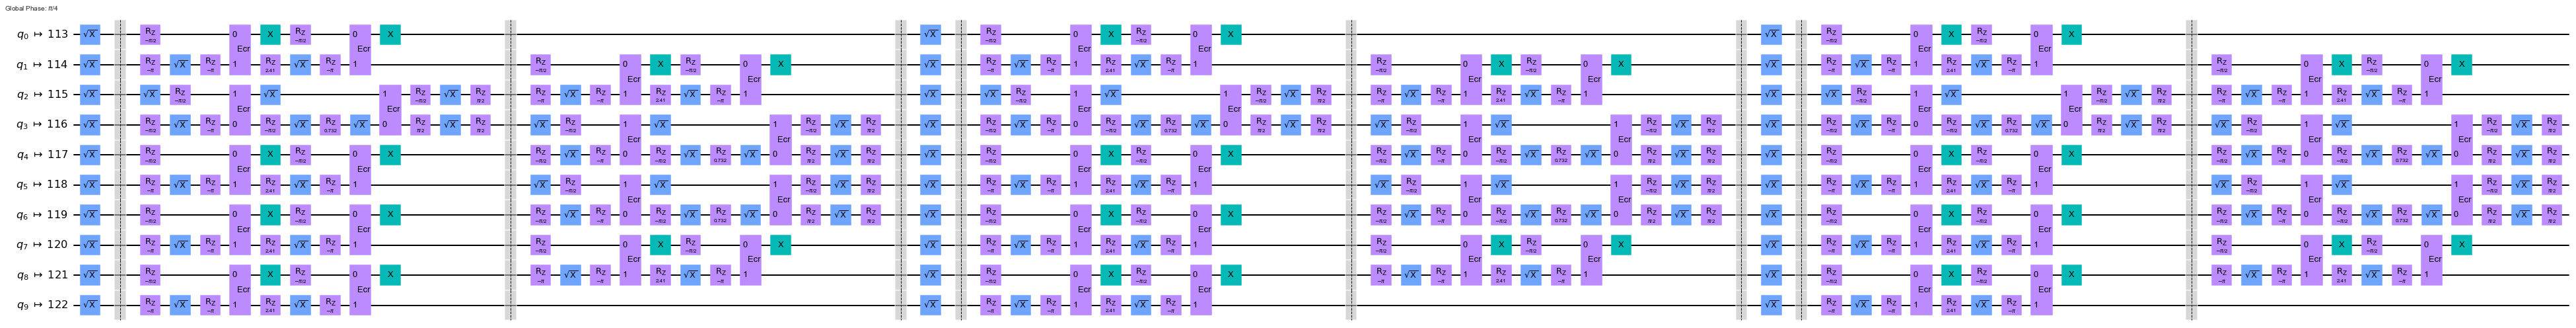

In [50]:
train_circuits[61].remove_final_measurements()
train_circuits[61].draw(**D)

In [17]:
# obs_list = ['I'*i+'Z'+'I'*(6-1-i) for i in range(6)]
# padded_obs = [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 6), 127)) for obs in obs_list]

obs_list = ['Z'+'I'*9, 'I'*2+'Z'+'I'*7, 'I'*4+'Z'+'I'*5, 'I'*6+'Z'+'I'*3, 'I'*9+'Z'+'I'*0]
padded_obs_all_circs = []
for trans_circuit in tqdm(train_circuits):
    padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 10), 127)) for obs in obs_list]

# obs_list = ['Z'+'I'*99, 'I'*19+'Z'+'I'*80, 'I'*29+'Z'+'I'*70, 'I'*39+'Z'+'I'*60, 'I'*49+'Z'+'I'*50]
# padded_obs_all_circs = []
# for trans_circuit in tqdm(train_circuits):
#     padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 100), 127)) for obs in obs_list]

  0%|          | 0/300 [00:00<?, ?it/s]

In [18]:
for i in range(150, 155):
    print(126-padded_obs_all_circs[i].paulis.to_labels()[0].find('Z'))

113
115
117
119
122


In [19]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
options = Options()
options.resilience_level = 2
options.optimization_level = 0
options.shots = 10000
options.resilience.noise_factors = (1, 3)
options.resilience.noise_amplifier = 'TwoQubitAmplifier'
options.resilience.extrapolator = 'LinearExtrapolator'
service = QiskitRuntimeService()

In [20]:
job_ids = []
num_circs_per_depth = 30
num_depths_per_job = 1
with Session(service=service, backend="ibm_sherbrooke") as session:
    runtime_estimator = RuntimeEstimator(session=session, options=options)
    for i in range(0, 10, num_depths_per_job):
        train_circuit_batch = train_circuits[num_circs_per_depth*i:num_circs_per_depth*(i+num_depths_per_job)]
        padded_obs_batch = padded_obs_all_circs[len(obs_list)*num_circs_per_depth*i:len(obs_list)*num_circs_per_depth*(i+num_depths_per_job)]
        assert len(train_circuit_batch) * len(obs_list) == len(padded_obs_batch)

        circ_to_submit = []
        for circ in train_circuit_batch:
            circ.remove_final_measurements()
            circ_to_submit.append(circ)

        job = runtime_estimator.run(
            circuits=np.repeat(np.array(circ_to_submit, dtype=QuantumCircuit), len(obs_list)),
            observables=padded_obs_batch
        )

        job_ids.append(job.job_id())
        print(job.job_id())
        print(len(circ_to_submit))

    with open('./data/ising_zne_hardware/10q_sherbrooke_30persteps_shots1w_sameJ_2_job_ids.pk', 'wb') as file:
        pickle.dump(job_ids, file)

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_93501/1625529279.py:17: FutureWarning: The input object of type 'RZGate' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'RZGate', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  circuits=np.repeat(np.array(circ_to_submit, dtype=QuantumCircuit), len(obs_list)),


chtb01b91dmpcngfvdjg
30
chtb01rgsimdkulgu4o0
30
chtb029oq2qn3r1peiqg
30
chtb031oq2qn3r1pejcg
30
chtb03ii3durlgqm03vg
30
chtb041oq2qn3r1pekbg
30
chtb04hvrup8981a8b20
30
chtb05hvrup8981a8bpg
30
chtb06bgsimdkulgu8tg
30
chtb07391dmpcngfvj90
30


In [48]:
with open('./data/ising_zne_hardware/100q_washington_30persteps_job_ids.pk', 'rb') as file:
    loaded = pickle.load(file)
loaded

['chrrp4qi3durlgpaqcp0',
 'chrrp8ai3durlgpaqg4g',
 'chrrpeai3durlgpaqmlg',
 'chrrpmgrecnk2p30564g',
 'chrrpuii3durlgpar880']

In [38]:
ret_job = service.job('chrm3c8recnk2p2nvl0g')

In [76]:
ret_job.status()

<JobStatus.RUNNING: 'job is actively running'>

In [21]:
qc = QuantumCircuit(1)
for _ in range(3):
    qc.rz(np.pi/2, 0)
    qc.sx(0)
    qc.rz(np.pi*3/2, 0)
    qc.sx(0)
    qc.rz(np.pi*5/2, 0)

Estimator().run(qc, SparsePauliOp('Z'), shots=None).result().values

array([-3.33066907e-16])

# Verification

In [ ]:
train_circuits[20].draw('mpl', fold=-1)

In [52]:
ideal_vals = []
noisy_vals = []
for circ in tqdm(train_circuits):
    counts_ideal = fake_backend_ideal.run(circ, shots=10000).result().get_counts()
    ideal_exp_vals = -1*cal_z_exp(counts_ideal)
    ideal_vals.extend(ideal_exp_vals)

    counts_noisy = fake_backend_noisy.run(circ, shots=10000).result().get_counts()
    noisy_exp_vals = -1*cal_z_exp(counts_noisy)
    noisy_vals.extend(noisy_exp_vals)

  0%|          | 0/300 [00:00<?, ?it/s]

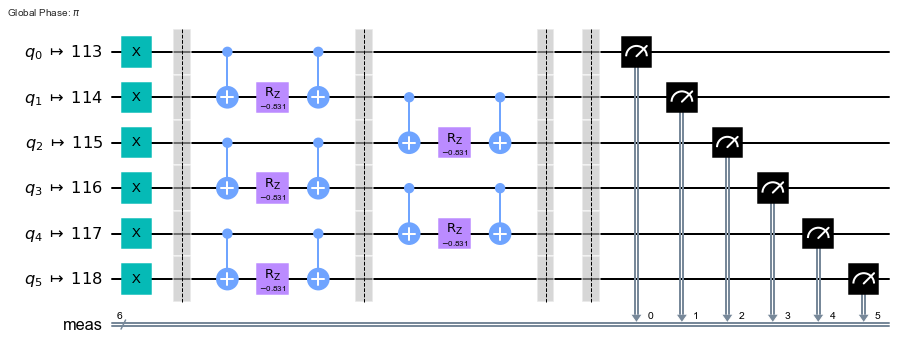

In [42]:
k = 30
train_circuits[k].draw('mpl', fold=-1, idle_wires=False)

In [56]:
for k in range(100):
    for i in range(6):
        print(ideal_vals[6*k+i], '\t', noisy_vals[6*k+i], '\t\t', mitigated_vals[6*k+i])

1.0 	 0.985 		 0.9026875000000006
1.0 	 0.9898 		 0.8343750000000014
1.0 	 0.9904 		 0.9795000000000004
1.0 	 0.9822 		 0.997812500000001
1.0 	 0.9718 		 0.9990625000000011
1.0 	 0.9806 		 0.9343125000000008
1.0 	 0.9836 		 0.9195625000000007
1.0 	 0.9906 		 0.7876250000000011
1.0 	 0.9926 		 0.9750000000000015
1.0 	 0.9802 		 0.9990000000000004
1.0 	 0.9722 		 0.999750000000001
1.0 	 0.9792 		 0.9556875000000012
1.0 	 0.9856 		 0.9241250000000005
1.0 	 0.992 		 0.832250000000001
1.0 	 0.9946 		 0.9763125000000015
1.0 	 0.9844 		 0.9993125000000014
1.0 	 0.969 		 0.9981875000000007
1.0 	 0.9802 		 0.9258125000000013
1.0 	 0.9826 		 0.9061875000000009
1.0 	 0.9898 		 0.7884375000000009
1.0 	 0.9926 		 0.9731250000000007
1.0 	 0.9818 		 0.9982500000000012
1.0 	 0.971 		 1.0008750000000008
1.0 	 0.9772 		 0.9335625000000003
1.0 	 0.9818 		 0.9362500000000014
1.0 	 0.9884 		 0.7810625000000002
1.0 	 0.993 		 0.970000000000001
1.0 	 0.9806 		 0.9995000000000013
1.0 	 0.9694 		 0.99668750000

In [ ]:
ideal_vals = []
for i in range(0, 15, 5):
    train_circuit_batch = train_circuits[20*i:20*(i+5)]
    for trans_circuit in train_circuit_batch:
        obs_list = ['I'*i+'Z'+'I'*(6-1-i) for i in range(6)]
        padded_obs = [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 6), 127)) for obs in obs_list]
        trans_circuit_copy = trans_circuit.copy()
        trans_circuit_copy.remove_final_measurements()
        exp_vals = Estimator().run([trans_circuit_copy]*6, padded_obs, shots=None).result().values
        ideal_vals.append(*exp_vals)